In [3]:
# imports
import sys
sys.path.append('../')
from ModelWrapper import ModelWrapper

In [5]:
from models.effnet_v import LitEffNetV
model_class = LitEffNetV
from utils.CustomDatasetImgVal import CustomDatasetImgVal
variables = ["CATID","SR_FR","LMSTAR"]
dataset_headings = "SR_FR"
model_params = {"in_channels": 1,"conditional_dim":1}
checkpoint_path = "../top_3/effnet2_epoch=19-step=880.ckpt"
from utils.Transformations import *
transformations = greyscale_downscale_random_crop_rotate_transform
effnet_wrapper = ModelWrapper(model_class,
                                dataset_headings,
                                CustomDatasetImgVal,
                                variables,
                                transformations,
                                model_name="effnet2",
                                model_params=model_params,
                                checkpoint_path=checkpoint_path)

Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b1
Loaded checkpoint: ../top_3/effnet2_epoch=19-step=880.ckpt


In [6]:
from models.resnet_v import LitResNetV
model_class = LitResNetV
from utils.CustomDatasetImgVal import CustomDatasetImgVal
variables = ["CATID","SR_FR","LMSTAR", "RE", "SIGMA_RE"]
dataset_headings = "SR_FR"
model_params = {"in_channels": 3,"conditional_dim":3}
checkpoint_path = "../top_3/resnet9_epoch=12-step=572.ckpt"
from utils.Transformations import *
transformations = downscale_centrecrop_rotate_transform
resnet_wrapper = ModelWrapper(model_class,
                                dataset_headings,
                                CustomDatasetImgVal,
                                variables,
                                transformations,
                                model_name="resnet9",
                                model_params=model_params,
                                checkpoint_path=checkpoint_path)

c:\Users\Siharath\Anaconda3\envs\lightning\lib\site-packages\lightning\pytorch\utilities\migration\utils.py:52: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.9, which is newer than your current Lightning version: v2.0.6
  rank_zero_warn(


Loaded checkpoint: ../top_3/resnet9_epoch=12-step=572.ckpt


In [7]:
from models.vit_v import LitViTV
model_class = LitViTV
from utils.CustomDatasetImgVal import CustomDatasetImgVal
variables = ["CATID","SR_FR","LMSTAR", "LAMBDAR_RE", "ELLIP"]
dataset_headings = "SR_FR"
model_params = {"in_channels": 3,"conditional_dim":3}
checkpoint_path = "../top_3/vit14_epoch=13-step=616.ckpt"
from utils.Transformations import *
transformations = downscale_centrecrop_rotate_transform
vit_wrapper = ModelWrapper(model_class,
                                dataset_headings,
                                CustomDatasetImgVal,
                                variables,
                                transformations,
                                model_name="vit14",
                                model_params=model_params,
                                checkpoint_path=checkpoint_path)

Loaded checkpoint: ../top_3/vit14_epoch=13-step=616.ckpt


In [9]:
y,preds,cat_ids = effnet_wrapper.predict_model()

correct_class = "SR"
correct_class_label = 1
model_name = "EfficientNet"

cat_ids_orig = cat_ids

# correct
correct_cat_ids = [cat_ids_orig[i] for i in range(len(cat_ids_orig)) if y[i] == preds[i] and y[i] == correct_class_label]
incorrect_cat_ids = [cat_ids_orig[i] for i in range(len(cat_ids_orig)) if y[i] != preds[i] and y[i] == correct_class_label]

# pick 3 correct and 2 incorrect
correct_cat_ids = correct_cat_ids[:3]
incorrect_cat_ids = incorrect_cat_ids[:2]

print("Correct: ", correct_cat_ids)
print("Incorrect: ", incorrect_cat_ids)

Correct:  ['7289', '16022', '70670']
Incorrect:  ['319402']


In [11]:
from torch.utils.data import DataLoader
import pandas as pd
df_test = pd.read_csv("../data/SR_FR_test.csv")
df_test = df_test[df_test["SR_FR"]==correct_class_label] # change this 1 = sr and 0 = fr
df_test = df_test[variables]
df_test["CATID"] = df_test["CATID"].astype(str)

df_background = df_test[~df_test["CATID"].isin(correct_cat_ids + incorrect_cat_ids)]
df_correct = df_test[df_test["CATID"].isin(correct_cat_ids)]
df_wrong = df_test[df_test["CATID"].isin(incorrect_cat_ids)]
df_sample = pd.concat([df_correct,df_wrong])
# sort sample by correct and incorrect according to correct_cat_ids and incorrect_cat_ids

background_dataset = CustomDatasetImgVal(df_background, transformations)
background_loader = DataLoader(background_dataset, batch_size=20, shuffle=False, num_workers=0)
input, target, vector, cat_ids = next(iter(background_loader))
background_data = [input,vector]

sample_dataset = CustomDatasetImgVal(df_sample, transformations)
sample_loader = DataLoader(sample_dataset, batch_size=5, shuffle=False, num_workers=0)
input, target, vector, cat_ids = next(iter(sample_loader))
test_data = [input[0:5],vector[0:5]]

In [13]:
from utils.ShapViewer import *
shap_values, test_numpy, shap_explainer = shap_deep_explainer_img_value_conditional(background_data, test_data, vit_wrapper.model)
shap_numpy = [shap_values[0][0].transpose(0,2,3,1),shap_values[1][0].transpose(0,2,3,1)]
test_numpy = test_data[0].cpu().numpy().transpose(0,2,3,1)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
# four examples
col1 = -350
col2 = 20
col3 = -700
m1 = -25
m2 = -25
m3 = 15
y=5
x=-1.25

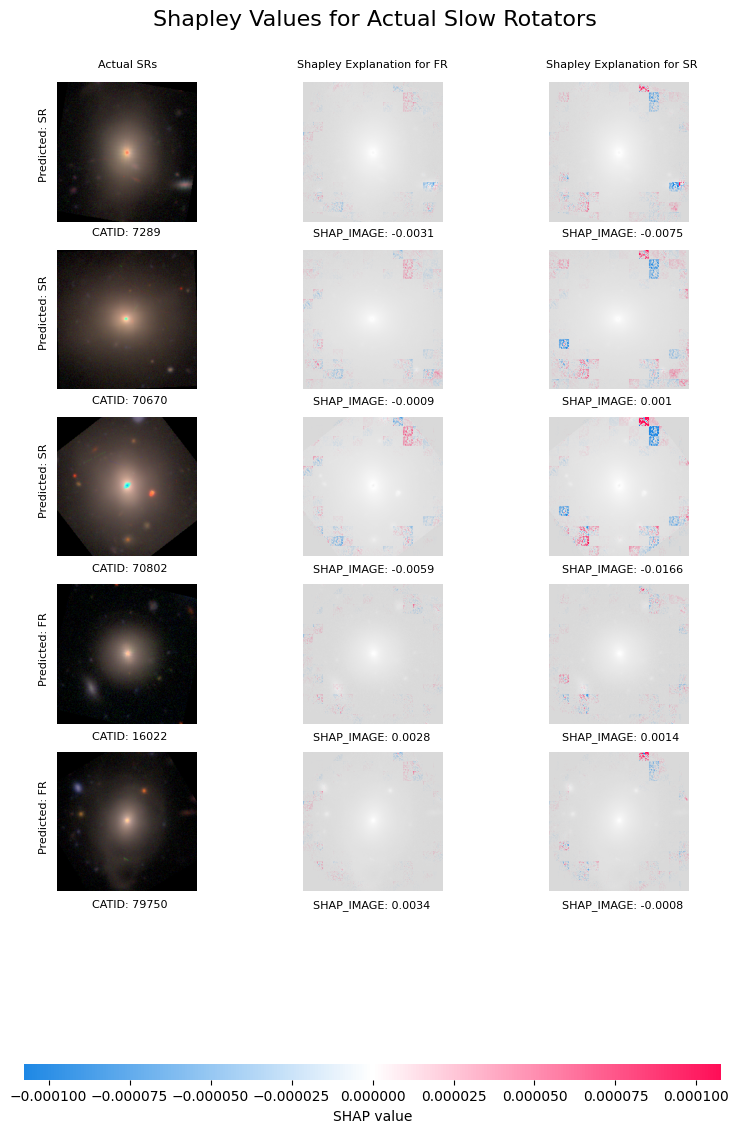

In [149]:
import shap
shap.image_plot(shap_numpy, test_numpy,show=False)
# title
import matplotlib.pyplot as plt
text_tile = "Fast Rotators"
if correct_class == "SR":
    text_tile = "Slow Rotators"

# five examples
y = 6.15
x = -1.25
col1 = -380
col2 = 20
col3 = -735
m1 = -25
m2 = -25
m3 = 10

plt.title(f"Shapley Values for Actual {text_tile}", loc="center", fontsize=16, y=y,x=x)
plt.text(col1+m1, -1100+270*(5-len(cat_ids)), "Shapley Explanation for FR", fontsize=8)
plt.text(col2+m2, -1100+270*(5-len(cat_ids)), "Shapley Explanation for SR", fontsize=8)
plt.text(col3+m3, -1100+270*(5-len(cat_ids)), f"Actual {correct_class}s", fontsize=8)

for i in range(len(cat_ids)):
    plt.text(col3, -1100+270*(i+1+(5-len(cat_ids))), "CATID: "+cat_ids[i], fontsize=8)


for i in range(len(cat_ids)):
    value = shap_numpy[0][i].flatten().sum()
    # round to 4dp
    value = round(value,4)
    plt.text(col1, -1100+270*(i+1+5-len(cat_ids)), "SHAP_IMAGE: "+ str(value), fontsize=8)


for i in range(len(cat_ids)):
    value = shap_numpy[1][i].flatten().sum()
    # round to 4dp
    value = round(value,4)
    plt.text(col2, -1100+270*(i+1 + 5-len(cat_ids)), "SHAP_IMAGE: "+ str(value), fontsize=8)

# plot correct and wrong rotated text
for i in range(3):
    plt.text(-820, -920+270*(i+5-len(cat_ids)), f"Predicted: {correct_class}", fontsize=8, rotation=90)

# plot correct and wrong rotated text
wrong_class = "FR" if correct_class == "SR" else "SR"
for i in range(3,len(cat_ids)):
    plt.text(-820, -920+270*(i+5-len(cat_ids)), f"Predicted: {wrong_class}", fontsize=8, rotation=90)

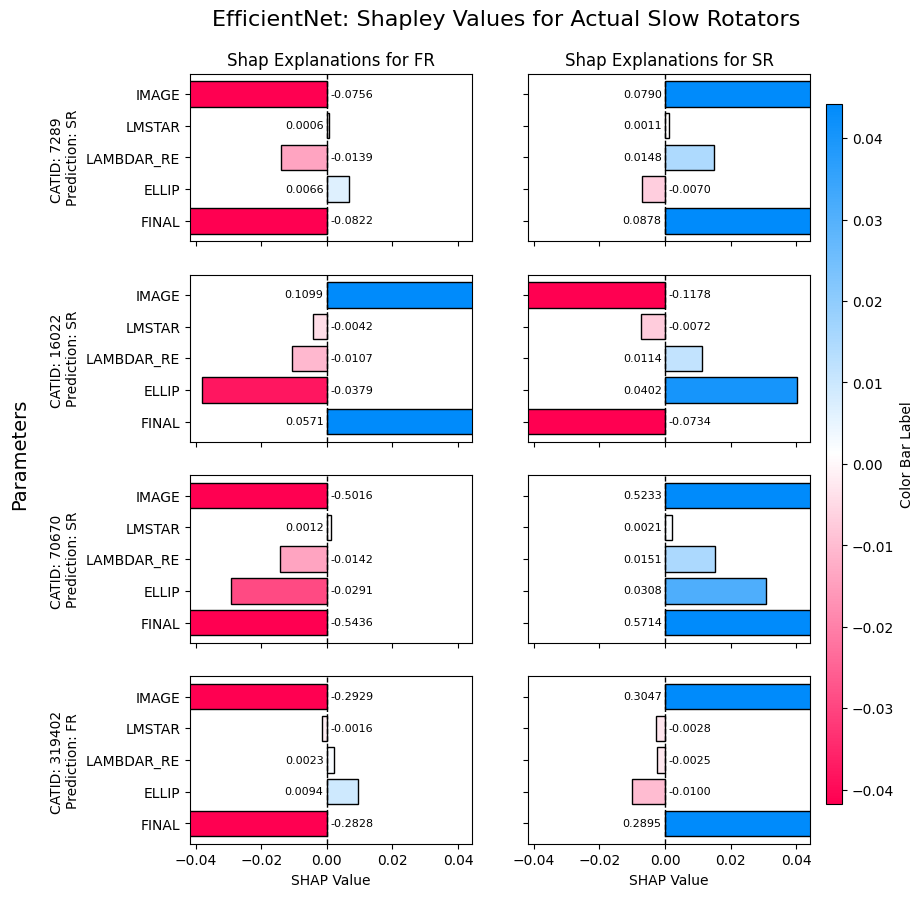

In [14]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

conditional_variables = variables[2:]
conditional_variables

fig, ax = plt.subplots(len(cat_ids), 2, figsize=(8, 10))
cmap_colors = ['#FF0051', '#FFFFFF', '#008BFB']  # Magenta to Blue
cmap = LinearSegmentedColormap.from_list('MagentaToBlue', cmap_colors, N=256)

tmp =  np.concatenate([shap_values[0][0].flatten(), shap_values[0][1].flatten(), shap_values[1][0].flatten(), shap_values[1][1].flatten()])
min_shap = min(tmp)*1.1
max_shap = max(tmp)*1.1

for i in range(len(cat_ids)):
    negative_class = shap_values[0][1][i]
    positive_class = shap_values[1][1][i]

    # Initialize conditional_variables as a list
    conditional_variables = ["IMAGE"] + variables[2:]
    conditional_variables = conditional_variables + ["FINAL"]

    # Calculate the sums as scalars
    negative_class_sum = shap_values[0][0][i].flatten().sum()
    positive_class_sum = shap_values[1][0][i].flatten().sum()

    # Convert negative_class and positive_class to lists
    negative_class = [negative_class_sum] + negative_class.tolist()
    negative_class.append(negative_class_sum + shap_values[0][1][i].flatten().sum())

    positive_class = [positive_class_sum] + positive_class.tolist()
    positive_class.append(positive_class_sum + shap_values[1][1][i].flatten().sum())

    # Normalize SHAP values to [0, 1] for proper colormap mapping
    negative_class = np.array(negative_class)
    positive_class = np.array(positive_class)
    negative_class_normalized = (negative_class - min_shap) / (max_shap - min_shap)
    positive_class_normalized = (positive_class - min_shap) / (max_shap - min_shap)
    negative_class = negative_class.tolist()
    positive_class = positive_class.tolist()

    # reverse the order of the labels to match the order of the bars
    conditional_variables = conditional_variables[::-1]
    negative_class = negative_class[::-1]
    positive_class = positive_class[::-1]
    negative_class_normalized = negative_class_normalized[::-1]
    positive_class_normalized = positive_class_normalized[::-1]

    # Plot negative class bars with color gradient
    # plot the bars in reverse order to match the order of the labels
 
    bars1 = ax[i,0].barh(conditional_variables, negative_class, label="FR", color=cmap(negative_class_normalized), edgecolor="black")
    bars2 = ax[i,1].barh(conditional_variables, positive_class, label="SR", color=cmap(positive_class_normalized), edgecolor="black")
    # vertical line at 0
    ax[i,0].axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax[i,1].axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax[i,1].set_yticklabels([])

    ax[i,0].set_xlim((min_shap, max_shap))
    ax[i,1].set_xlim((min_shap, max_shap))
    
    if i == len(cat_ids)-1:
        ax[i,0].set_xlabel("SHAP Value")
        ax[i,1].set_xlabel("SHAP Value")
        
    else:
        # no xticks
        ax[i,0].set_xticklabels([])
        ax[i,1].set_xticklabels([])
    
    status = f"Prediction: {correct_class}"
    incorrect_status = "Prediction: FR" if correct_class == "SR" else "Prediction: SR"
    if i > 2:
        status = incorrect_status

    ax[i,0].set_ylabel(f"CATID: {cat_ids[i]} \n{status}")

    if i ==0:
        ax[i,0].set_title("Shap Explanations for FR")
        ax[i,1].set_title("Shap Explanations for SR")

    # Annotate bars with SHAP values
    for bar1, bar2, value1, value2 in zip(bars1, bars2, negative_class, positive_class):
        pos1 = bar1.get_width()
        pos2 = bar2.get_width()
        halign1 = 'left'
        halign2 = 'left'

        margin = 0.001
        if pos1 < 0:
            pos1 = margin
        else:
            pos1 = -margin
            halign1 = 'right'

        if pos2 < 0:
            pos2 = margin
        else:
            pos2 = -margin
            halign2 = 'right'
        
        ax[i,0].text(pos1 , bar1.get_y() + bar1.get_height() / 2, f"{value1:.4f}", ha=halign1, va='center', fontsize=8)
        ax[i,1].text(pos2 , bar2.get_y() + bar2.get_height() / 2, f"{value2:.4f}", ha=halign2, va='center',fontsize=8)

# Add color bar for negative class
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define the position of the color bar
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_shap, vmax=max_shap))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label("Color Bar Label")  # You can customize the label as needed

# add main ylabel
fig.text(-0.1, 0.5, 'Parameters', va='center', rotation='vertical', fontsize=14)

title_text = "Fast Rotators"
if correct_class == "SR":
    title_text = "Slow Rotators"
plt.title(f"EfficientNet: Shapley Values for Actual {title_text}", loc="center", fontsize=16, y=1.1,x=-20)

plt.show()